<a href="https://colab.research.google.com/github/ASerraMartin/SAC_Spark/blob/main/SAC_Spark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Imports and Spark environment setup**

In [17]:
from pyspark import SparkContext, SparkConf
from string import ascii_uppercase
import matplotlib.pyplot as plt
import networkx as nx
import random

---
### **Auxiliary functions**

#### Graph generation function
Generation function sourced from:
https://networkx.org/documentation/stable/reference/generated/networkx.generators.random_graphs.gnp_random_graph.html

In [18]:
def generate_random_graph(n, p, weight_range, seed=45):
    """
    Generates a random directed graph, with n nodes, p probability of connection
    between node pairs and random edge weights whitin the specified range
    (weight_range). It also has a seed to allow graph reproductibility.
    """

    # Generate the random directed graph, now with numbers as node names
    G_numbers = nx.gnp_random_graph(n, p, directed=True, seed=seed)

    # Map the node names to letters, ordered alphabetically
    mapping = {i: ascii_uppercase[i] for i in range(n)}
    G_letters = nx.relabel_nodes(G_numbers, mapping)

    # Add random weights, within the specified range, to the edges
    for u, v in G_letters.edges():
        G_letters.edges[u, v]["weight"] = int(random.randint(*weight_range))

    return G_letters

#### Graph preprocessing function

In [19]:
def preprocess_pyspark_graph(G, source_node):
    """
    Converts a NetworkX graph G into a list format compatible with PySpark. The specified
    source node will serve as the initial node for the Dijkstra shortest-path algorithm.
    """

    pyspark_graph = []

    for node in G.nodes():

        # Get a tuple list of neighbors (neighbor, weight) for the current node
        neighbors = [(nbr, G.edges[node, nbr]["weight"]) for nbr in G.successors(node)]

        # Initialize the node's distance (0 for the source, infinite otherwise)
        initial_weight = 0 if node == source_node else float("inf")

        # Establish the node's initial state
        state = (
            neighbors,
            initial_weight,
            False,              # Not processed/visited
            [source_node],      # No known path to reach it yet, only the starting node is known
        )

        pyspark_graph.append((node, state))

    return pyspark_graph

#### Graph plotting and printing functions

In [20]:
def plot_graph(G, solution=False, source_node="A", spark_solution=None):
    """
    Plots the given NetworkX directed graph (networkx.DiGraph) G, naming each node
    and showing every edge between nodes as an arrow with its associated weight
    (plt.show() must be added after the function call to plot it on screen).

    If solution is True, it also shows the shortest paths from source_node to every
    other node, using NetworkX's Dijkstra implementation.

    If a PySpark-style graph is given as a spark_solution, it will show its calculated
    shortest paths using this own Dijkstra shortest path implementation using Spark.
    """

    # Establish a general purpose layout for any graph
    layout = nx.circular_layout(G)

    # Plot the nodes
    node_color = "lightblue"
    nx.draw_networkx_nodes(G, layout, node_color=node_color, node_size=300)
    nx.draw_networkx_labels(G, layout)

    # Plot the base edges
    nx.draw_networkx_edges(G, layout, edge_color="gray", width=0.5)
    nx.draw_networkx_edge_labels(G, layout, edge_labels=nx.get_edge_attributes(G, "weight"))

    # Show the solution using NetworkX's Dijkstra implementation
    if solution:
        _, paths = nx.single_source_dijkstra(G, source=source_node, weight="weight")

        # Collect all the edges involved in some path
        edges = set()
        for path in paths.values():
            for i in range(len(path) - 1):
                edges.add((path[i], path[i + 1]))

        # Highlight paths in red
        nx.draw_networkx_edges(G, layout, edgelist=edges, edge_color="red")

    # Show the solution using the Spark Dijkstra implementation
    elif spark_solution:

        edges = set()
        for node_data in spark_solution:
            path = node_data[1][3]
            for i in range(len(path) - 1):
                edges.add((path[i], path[i + 1]))

        # Highlight paths in blue
        nx.draw_networkx_edges(G, layout, edgelist=edges, edge_color="blue")

In [21]:
def print_pyspark_data(data):
    """
    Prints a formatted output showing the information of a PySpark-format directed graph.
    """

    # Header with aligned columns
    print(f"{'='*85}")
    print(f"{'Node':<5} | {'Weight':<8} | {'Path':<30} | {'Neighbors (Dest, Cost)'}")
    print(f"{'-'*85}")

    # Each node, also with aligned columns
    for node, (neighbors, weight, visited, path) in data:

        # Format for the weight, path and neighbors list
        weight_str = "Inf" if weight == float('inf') else f"{weight}"
        path_str = "Unknown" if weight == float('inf') else " -> ".join(path)
        neighbors_str = ", ".join([f"({u}, {v})" for u, v in neighbors])

        print(f"{node:<5} | {weight_str:<8} | {path_str:<30} | {neighbors_str}")

    print(f"{'='*85}\n")

---

### **Initial graph construction**

#### Generation

In [22]:
# Given example graph
G = nx.DiGraph()
G.add_weighted_edges_from(
    [
        ("A", "B", 3),
        ("A", "C", 10),
        ("A", "E", 4),
        ("B", "C", 2),
        ("B", "D", 8),
        ("B", "F", 7),
        ("C", "D", 5),
        ("C", "G", 3),
        ("D", "H", 6),
        ("E", "F", 2),
        ("E", "I", 9),
        ("F", "G", 1),
        ("F", "J", 5),
        ("G", "H", 2),
        ("G", "K", 4),
        ("I", "J", 3),
        ("J", "K", 6),
    ]
)

# Example of a randomly generated directed graph of 10 nodes,
# with a 15% probability of forming an edge between two nodes,
# and edge weights ranging from 1 to 10 (the internal random seed is 45)
G_rand = generate_random_graph(10, 0.15, (1, 10))

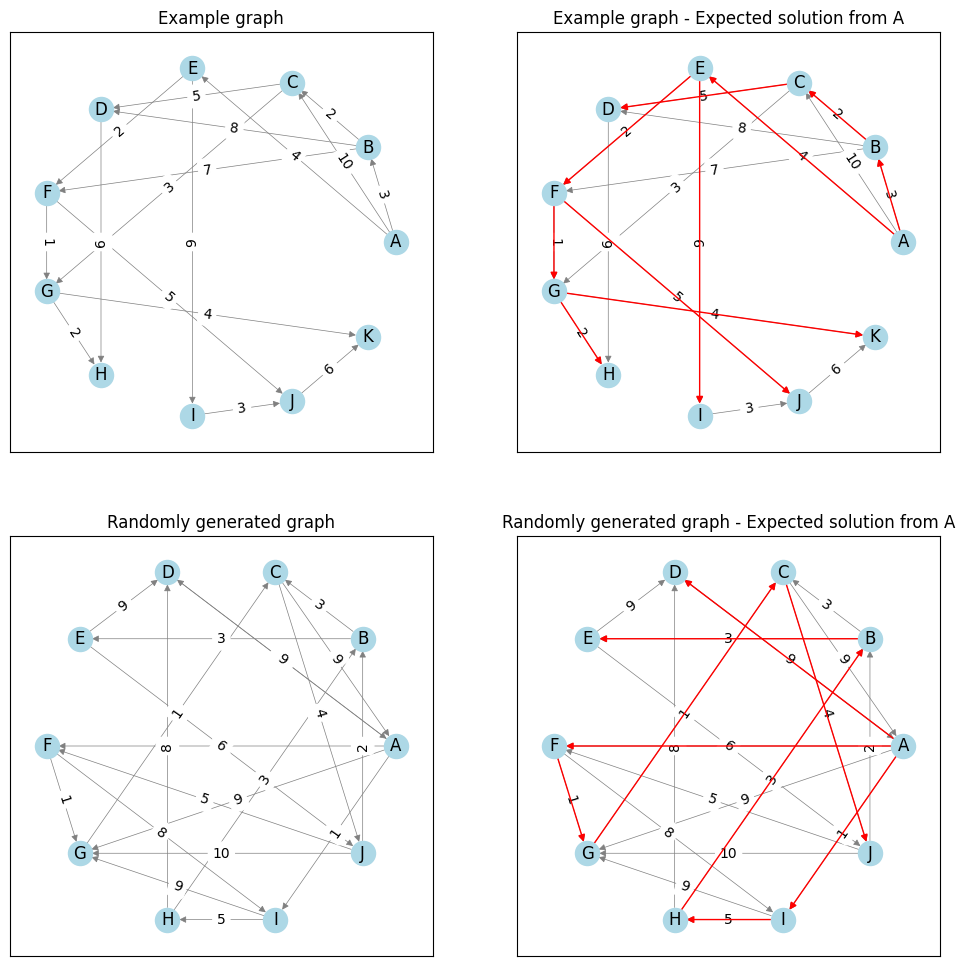

In [23]:
plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
plt.title("Example graph")
plot_graph(G)

plt.subplot(2, 2, 2)
plt.title("Example graph - Expected solution from A")
plot_graph(G, solution=True, source_node="A")

plt.subplot(2, 2, 3)
plt.title("Randomly generated graph")
plot_graph(G_rand)

plt.subplot(2, 2, 4)
plt.title("Randomly generated graph - Expected solution from A")
plot_graph(G_rand, solution=True, source_node="A")

plt.show()

#### Pre-processing

In [24]:
# Adapt the NetworkX-style graphs to be able to work with Spark RDDs
G_pyspark = preprocess_pyspark_graph(G, "A")
G_rand_pyspark = preprocess_pyspark_graph(G_rand, "A")

In [25]:
print("EXAMPLE GRAPH")
print_pyspark_data(G_pyspark)

print("RANDOMLY GENERATED GRAPH")
print_pyspark_data(G_rand_pyspark)

EXAMPLE GRAPH
Node  | Weight   | Path                           | Neighbors (Dest, Cost)
-------------------------------------------------------------------------------------
A     | 0        | A                              | (B, 3), (C, 10), (E, 4)
B     | Inf      | Unknown                        | (C, 2), (D, 8), (F, 7)
C     | Inf      | Unknown                        | (D, 5), (G, 3)
E     | Inf      | Unknown                        | (F, 2), (I, 9)
D     | Inf      | Unknown                        | (H, 6)
F     | Inf      | Unknown                        | (G, 1), (J, 5)
G     | Inf      | Unknown                        | (H, 2), (K, 4)
H     | Inf      | Unknown                        | 
I     | Inf      | Unknown                        | (J, 3)
J     | Inf      | Unknown                        | (K, 6)
K     | Inf      | Unknown                        | 

RANDOMLY GENERATED GRAPH
Node  | Weight   | Path                           | Neighbors (Dest, Cost)
----------------------

---

### **Dijkstra shortest-path iterative algorithm**

#### Spark auxiliary functions for Dijkstra's algorithm

In [26]:
def unprocessed_nodes(nodes):
    """
    Returns the nodes from the given RDD graph that have not been processed yet.
    """

    return nodes.filter(lambda x: not x[1][2])

In [27]:
def update_node_logic(node_data, current_name, current_neighbors, current_weight, current_path):
    """
    Updates a RDD node's state based on the currently processed node.

    When this function is used in a map inside the Dijkstra solution, each node
    from the RDD will be modified (or not) using the current node of the algorithm
    as a reference to apply the correct update.
    """

    name, (neighbors, weight, visited, path) = node_data

    # If the updated node is the current iteration node, mark it as visited
    if name == current_name:
        return (name, (neighbors, weight, True, path))

    else:
        # Check if this node can be reached from the current iteration node
        # (i.e.: if both nodes are neighbors)
        current_to_node_weight = None
        for nbr, wgt in current_neighbors:
            if nbr == name:
                current_to_node_weight = wgt
                break

        # If the nodes are neighbors, update the path if the new one is better
        if current_to_node_weight is not None:
            new_weight = current_weight + current_to_node_weight
            if new_weight < weight:
                return (name, (neighbors, new_weight, visited, current_path + [name]))

    # No update in any other case
    return node_data

#### Shortest-path algorithm solution

In [28]:
def solve_dijkstra(graph_data):
    """
    Calculates the shortest paths from the source node to all reachable nodes using
    a distributed Dijkstra algorithm via Spark RDDs.

    The function iteratively selects the minimum-weight unprocessed node and performs
    a parallel update of all nodes and its paths across the graph based on the selected
    node. It relies on RDD caching to manage the execution history and prevent memory errors.

    It returns an updated PySpark-style list like the one it receives (graph_data), now
    with the solutions for the shortest paths from the source node.
    """

    nodes = sc.parallelize(graph_data)

    # Loop to implement the iterative algorithm, until all nodes have been processed
    while unprocessed_nodes(nodes).count() > 0:

        # Get the unprocessed node with the minimum weight (current node for this iteration)
        unprocessed = unprocessed_nodes(nodes)
        current_node = unprocessed.reduce(lambda a, b: a if a[1][1] < b[1][1] else b)

        # Update all nodes in parallel using a map and the auxiliary function
        nodes = nodes.map(
            lambda x: update_node_logic(
                x,
                current_node[0],        # Current node's name
                current_node[1][0],     # Current node's neighbors
                current_node[1][1],     # Current node's weight
                current_node[1][3],     # Current node's path
            )
        )

        # Cache the RDD and force its computation so Spark keeps only the current state.
        # This prevents performance issues and memory errors during long iterative
        # algorithms by avoiding an excessively long execution history
        nodes.cache()
        nodes.count()

    return nodes.collect()

In [29]:
# Initialize the Spark configuration and create a Spark context for the application
conf = SparkConf().setMaster("local").setAppName("Dijkstra")
sc = SparkContext.getOrCreate(conf=conf)

In [30]:
G_solved = solve_dijkstra(G_pyspark)
G_rand_solved = solve_dijkstra(G_rand_pyspark)

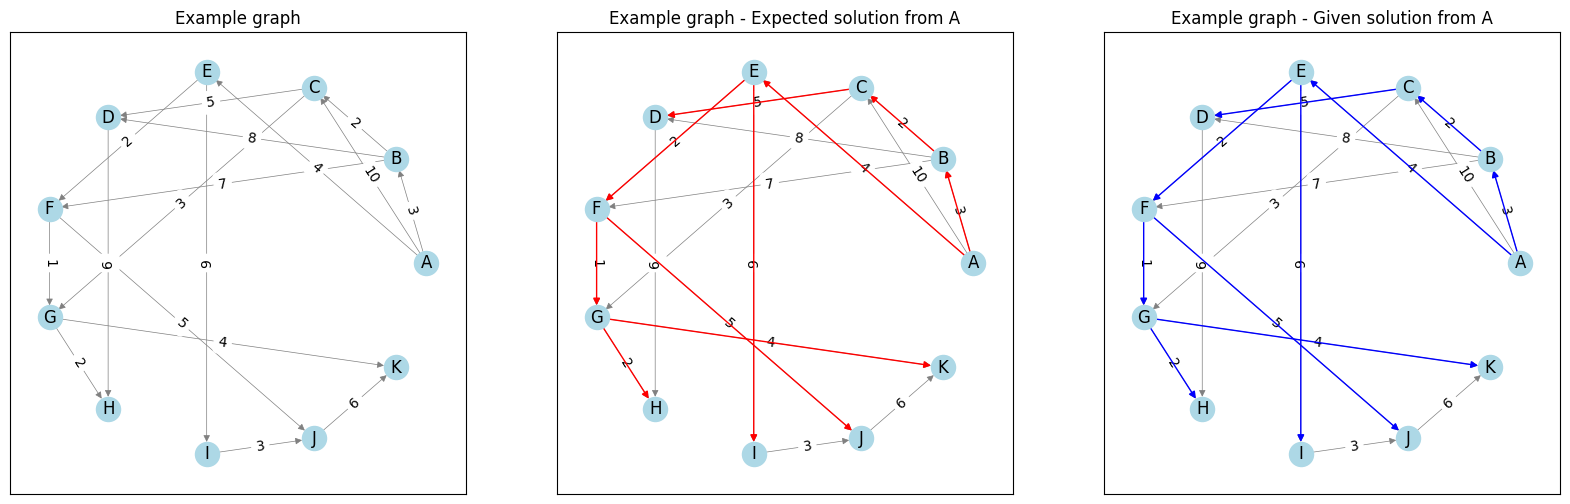



EXAMPLE GRAPH
Node  | Weight   | Path                           | Neighbors (Dest, Cost)
-------------------------------------------------------------------------------------
A     | 0        | A                              | (B, 3), (C, 10), (E, 4)
B     | Inf      | Unknown                        | (C, 2), (D, 8), (F, 7)
C     | Inf      | Unknown                        | (D, 5), (G, 3)
E     | Inf      | Unknown                        | (F, 2), (I, 9)
D     | Inf      | Unknown                        | (H, 6)
F     | Inf      | Unknown                        | (G, 1), (J, 5)
G     | Inf      | Unknown                        | (H, 2), (K, 4)
H     | Inf      | Unknown                        | 
I     | Inf      | Unknown                        | (J, 3)
J     | Inf      | Unknown                        | (K, 6)
K     | Inf      | Unknown                        | 

EXAMPLE GRAPH - SOLVED
Node  | Weight   | Path                           | Neighbors (Dest, Cost)
----------------------

In [31]:
# Solved example graph
plt.figure(figsize=(20, 6))

plt.subplot(1, 3, 1)
plt.title("Example graph")
plot_graph(G)

plt.subplot(1, 3, 2)
plt.title("Example graph - Expected solution from A")
plot_graph(G, solution=True, source_node="A")

plt.subplot(1, 3, 3)
plt.title("Example graph - Given solution from A")
plot_graph(G, spark_solution=G_solved)

plt.show()

# Graph data
print("\n")
print("EXAMPLE GRAPH")
print_pyspark_data(G_pyspark)
print("EXAMPLE GRAPH - SOLVED")
print_pyspark_data(G_solved)

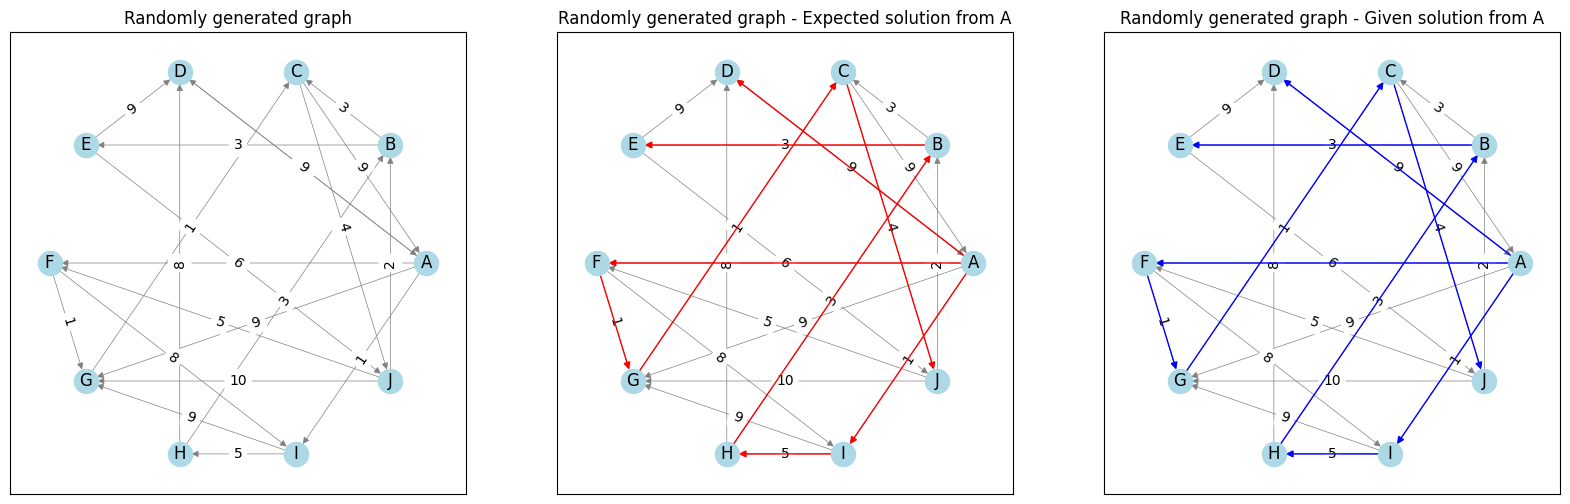



RANDOMLY GENERATED GRAPH
Node  | Weight   | Path                           | Neighbors (Dest, Cost)
-------------------------------------------------------------------------------------
A     | 0        | A                              | (D, 10), (F, 4), (G, 9), (I, 1)
B     | Inf      | Unknown                        | (C, 3), (E, 3)
C     | Inf      | Unknown                        | (A, 9), (J, 4)
D     | Inf      | Unknown                        | (A, 9)
E     | Inf      | Unknown                        | (D, 9), (J, 6)
F     | Inf      | Unknown                        | (G, 1), (I, 8)
G     | Inf      | Unknown                        | (C, 1)
H     | Inf      | Unknown                        | (B, 3), (D, 8)
I     | Inf      | Unknown                        | (G, 9), (H, 5)
J     | Inf      | Unknown                        | (B, 2), (F, 5), (G, 10)

RANDOMLY GENERATED GRAPH - SOLVED
Node  | Weight   | Path                           | Neighbors (Dest, Cost)
----------------------

In [32]:
# Solved randomly generated graph
plt.figure(figsize=(20, 6))

plt.subplot(1, 3, 1)
plt.title("Randomly generated graph")
plot_graph(G_rand)

plt.subplot(1, 3, 2)
plt.title("Randomly generated graph - Expected solution from A")
plot_graph(G_rand, solution=True, source_node="A")

plt.subplot(1, 3, 3)
plt.title("Randomly generated graph - Given solution from A")
plot_graph(G_rand, spark_solution=G_rand_solved)

plt.show()

# Graph data
print("\n")
print("RANDOMLY GENERATED GRAPH")
print_pyspark_data(G_rand_pyspark)
print("RANDOMLY GENERATED GRAPH - SOLVED")
print_pyspark_data(G_rand_solved)